# 8 Rrecurrent Neural Networks
## 8.1 Sequence Models
### 8.1.1 Statisticcal Tools
$$x_t\sim P(x_t|x_{t-1},\cdots,x_1)$$
#### Autoregressive Models
$$P(x_1,\cdots,x_T)=\prod_{t=1}^T P(x_t|x_{t-1},\cdots,x_1)$$
#### Markov Models
$$P(x_1,\cdots,x_T)=\prod_{t=1}^T P(x_t|x_{t-1})\text{ where } P(x_1|x_0)=P(x_1)$$
$$
\begin{align*}
    P(x_{t+1}|x_{t-1})
        &=\frac{\sum_{x_t}P(x_{t+1},x_t,x_{t-1})}{P(x_{t-1})}\\
        &=\frac{\sum_{x_t}P(x_{t+1}|x_t,x_{t-1})P(x_t,x_{t-1})}{P(x_{t-1})}\\
        &=\sum_{x_t}P(x_{t+1}|x_t)P(x_t|x_{t-1})
\end{align*}
$$
#### Causality
$$P(x_1,\cdots,x_T)=\prod_{t=T}^1 P(x_t|x_{t+1},\cdots,x_T)$$

In [1]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import nn
npx.set_np()

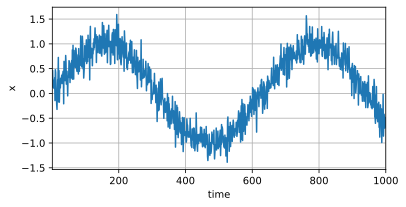

In [2]:
T=1000
time=np.arange(1,T+1,dtype=np.float32)
x=np.sin(0.01*time)+np.random.normal(0,0.2,(T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1,1000], figsize=(6,3))

In [3]:
tau = 4
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = d2l.reshape(x[tau:], (-1, 1))
print(features[3,0]==features[2,1]==features[1,2]==features[0,3])
features[0:10,0],features[0:10,1],features[0:10,2],features[0:10,3]

True


(array([ 0.24261554,  0.4624399 ,  0.12675641,  0.1947901 ,  0.10989186,
         0.26865208,  0.10054794,  0.3166998 , -0.14388442,  0.4781757 ]),
 array([ 0.4624399 ,  0.12675641,  0.1947901 ,  0.10989186,  0.26865208,
         0.10054794,  0.3166998 , -0.14388442,  0.4781757 ,  0.42139256]),
 array([ 0.12675641,  0.1947901 ,  0.10989186,  0.26865208,  0.10054794,
         0.3166998 , -0.14388442,  0.4781757 ,  0.42139256, -0.12723608]),
 array([ 0.1947901 ,  0.10989186,  0.26865208,  0.10054794,  0.3166998 ,
        -0.14388442,  0.4781757 ,  0.42139256, -0.12723608,  0.02044523]))

In [4]:
def get_net():
    # A simple MLP
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'),
            nn.Dense(1))
    net.initialize(init.Xavier())
    return net

In [5]:
def train(net, train_iter, loss, epochs, batch_size, lr):
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    for epoch in range(epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        print(f'epoch {epoch + 1}, loss:{d2l.evaluate_loss(net, train_iter, loss)}')

In [6]:
n_train = 600
batch_size, num_epochs, lr = 16, 5, 0.1
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)
loss = gluon.loss.L2Loss()
net = get_net()
train(net, train_iter, loss, num_epochs, batch_size, lr)

epoch 1, loss:0.04385889947414398
epoch 2, loss:0.02641602965692679
epoch 3, loss:0.027259528984626136
epoch 4, loss:0.025933070828517278
epoch 5, loss:0.03562307670712471


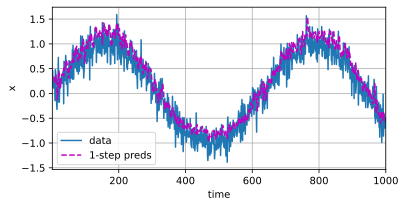

In [7]:
# 8.1.3 Prediction
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [d2l.numpy(x), d2l.numpy(onestep_preds)], 
        'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

In [22]:
time[0:10],time[tau:10],time.size,d2l.numpy(x[0:10]),x.size,d2l.numpy(onestep_preds[0:10]),onestep_preds.size

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([ 5.,  6.,  7.,  8.,  9., 10.]),
 1000,
 array([ 0.24261554,  0.4624399 ,  0.12675641,  0.1947901 ,  0.10989186,
         0.26865208,  0.10054794,  0.3166998 , -0.14388442,  0.4781757 ],
       dtype=float32),
 1000,
 array([[ 0.08168635],
        [ 0.05451402],
        [ 0.01045302],
        [ 0.01536828],
        [ 0.02864063],
        [-0.00365227],
        [ 0.00589955],
        [ 0.08789951],
        [ 0.02630866],
        [ 0.02729991]], dtype=float32),
 996)

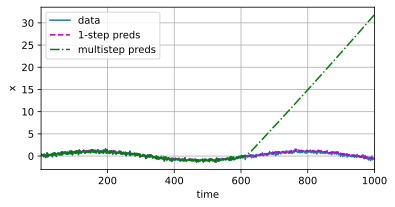

In [38]:
multistep_preds = np.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = d2l.reshape(net(multistep_preds[i - tau:i].reshape(1, -1)), 1)
d2l.plot([time, time[tau:], time], [x.asnumpy(), d2l.numpy(onestep_preds), multistep_preds.asnumpy()], 'time', 'x',
        legend=['data', '1-step preds', 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))
# d2l.plot([time, time[tau:], time[n_train + tau:]], [x.asnumpy(), d2l.numpy(onestep_preds), 
#         d2l.numpy(multistep_preds[n_train + tau:])], 'time', 'x',
#         legend=['data', '1-step preds', 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

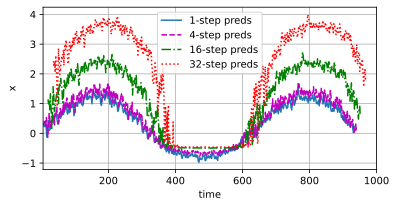

In [53]:
max_steps = 64
features = np.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1].T
for i in range(tau, tau + max_steps):
    features[:, i] = d2l.reshape(net(features[:, i - tau:i]), -1)
steps = (1, 4, 16, 32)
x_steps = [time[tau + i - 1:T - max_steps + i] for i in steps]
y_steps = [features[:, tau + i - 1].asnumpy() for i in steps]
d2l.plot(x_steps, y_steps, 'time', 'x', legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000], figsize=(6, 3))

In [51]:
len(x_steps[0]),len(y_steps[0]),features.shape,net(features[:,0:tau]).shape

(933, 933, (933, 68), (933, 1))

ToDo: 需要进一步理解其数学原理